# Fortschrittsanzeige und Datentransformationen

Häufig wirst du in Jupyter-Notebooks mit Daten arbeiten. Manchmal können Operationen *lange dauern* und du möchtest jeweils immer über den aktuellen Status informiert sein.

Sehr oft liegen Daten nicht in exakt der Form vor, in der du sie für die Weiterverarbeitung benötigst. In `pandas` gibt es sehr leistungsfähige Operationen zur *Datentransformation*, die du hier kennenlernen wirst.

## Fortschrittsanzeige

Damit du keine separate Schleife mit langer Laufzeit implementieren musst, simulierst du das einfach mit einem `sleep`, der die Laufzeit der Anweisung in der Schleife auf etwa 10ms erhöht.

In [1]:
import time
for i in range(1000):
    time.sleep(0.01)

Nach 10s ist der Spuk vorbei, so lange kannst du natürlich warten. Oft dauert es aber deutlich länger und du möchtest wissen, wie weit der Prozess schon fortgeschritten ist.

Dabei hilft dir das Paket `tqdm`. Statt `range` verwendest du einfach `trange`, ansonsten ändert sich nichts. Allerdings sieht das Ergebnis schon etwas anders aus:

In [2]:
from tqdm.auto import trange
for i in trange(1000):
    time.sleep(0.01)

  0%|          | 0/1000 [00:00<?, ?it/s]

Neben dem Fortschritt zeigt `tqdm` auch noch den prozentualen Fertigstellungsgrad, die Iterationen pro Sekunde und die erwartete Restlaufzeit an. Das wirst du oft brauchen, es ist super nützlich.

Es ist natürlich ziemlich praktisch, dass `tqdm` die Funktion `trange` anbietet. Aber sicher möchtest du nicht immer nur mit `range` arbeiten, sondern hast oft auch andere Objekte.

Zum Glück kann `tqdm` auch damit umgehen. Bei bestimmten (iterierbaren) Objekten musst du noch den Parameter `total` eingeben, damit die gesamte Laufzeit abgeschätzt werden kann. Bei `range` ist das nicht notwendig.

`tqdm` kann außerdem auch mit geschachtelten Schleifen umgehen:

In [3]:
from tqdm.auto import tqdm
for i in tqdm(range(10), desc="first"):
    for j in tqdm(range(100), desc="second"):
        time.sleep(0.01)

first:   0%|          | 0/10 [00:00<?, ?it/s]

second:   0%|          | 0/100 [00:00<?, ?it/s]

second:   0%|          | 0/100 [00:00<?, ?it/s]

second:   0%|          | 0/100 [00:00<?, ?it/s]

second:   0%|          | 0/100 [00:00<?, ?it/s]

second:   0%|          | 0/100 [00:00<?, ?it/s]

second:   0%|          | 0/100 [00:00<?, ?it/s]

second:   0%|          | 0/100 [00:00<?, ?it/s]

second:   0%|          | 0/100 [00:00<?, ?it/s]

second:   0%|          | 0/100 [00:00<?, ?it/s]

second:   0%|          | 0/100 [00:00<?, ?it/s]

Sobald du längere Operationen in Schleifen durchführst, solltest du `tqdm` verwenden. Der zusätzliche Aufwand ist praktisch vernachlässigbar und du erhältst wesentlich mehr Kontrolle über deine Notebooks und den jeweiligen Bearbeitungsstand.

Übrigens funktioniert `tqdm` auch auf der Konsole ziemlich gut und gibt dort (in ASCII-Zeichen) genau die gleichen Informationen aus!

## Datentransformation

Häufig kannst du dir das Format nicht aussuchen, in dem Daten vorliegen. Im Gegenteil, in den allermeisten Fällen ist es schon ein ganz großes Glück, wenn du überhaupt Daten findest und auf die zugreifen kannst.

Einen großen Fundus an Daten bietet dir [Eurostat](https://ec.europa.eu/eurostat), die Statistik-Behörde der Europäischen Union. Natürlich handelt es sich dabei um sehr spezielle Daten, allerdings hast du den großen Vorteil, dass du die Daten frei verwenden darfst und das Herunterladen kein Problem ist. Dafür gibt es nämlich ein Python-Paket `eurostat`:

In [ ]:
pip install eurostat

Alle Statistikdaten haben bei Eurostat ein Kürzel. In diesem Beispiel beschäftigst du dich mit den *Konsumindikatoren*, diese tragen das Kürzel `ei_bsco_m`. Es handelt sich dabei um sog. *business and consumer surveys*, die monatlich verdichtet sind (alternativ könntest du die auch auf das Quartal aggregiert herunterladen). Eine genauere Erklärung findest du [hier](https://ec.europa.eu/eurostat/cache/metadata/en/ei_bcs_esms.htm). 

Das Herunterladen der Daten ist nun sehr einfach:

In [4]:
import eurostat
df = eurostat.get_data_df("ei_bsco_m")

Betrachte im nächsten Schritt die Daten:

In [5]:
df

,freq,indic,s_adj,unit,geo\TIME_PERIOD,1980-01,1980-02,1980-03,1980-04,1980-05,...,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11
0,M,BS-CSMCI,NSA,BAL,AL,NaN,NaN,NaN,NaN,NaN,...,-15.6,-24.9,-26.0,-23.2,-22.2,-22.1,-19.6,-22.2,-23.3,-22.4
1,M,BS-CSMCI,NSA,BAL,AT,NaN,NaN,NaN,NaN,NaN,...,-7.3,-22.0,-21.0,-24.2,-24.8,-34.1,-31.7,-32.6,-31.1,-29.9
2,M,BS-CSMCI,NSA,BAL,BE,NaN,NaN,NaN,NaN,NaN,...,-9.9,-21.8,-18.7,-18.0,-17.3,-18.9,-18.4,-28.1,-28.5,-24.1
3,M,BS-CSMCI,NSA,BAL,BG,NaN,NaN,NaN,NaN,NaN,...,-20.6,-29.7,-29.2,-32.2,-29.4,-26.9,-28.2,-30.6,-28.1,-27.8
4,M,BS-CSMCI,NSA,BAL,CY,NaN,NaN,NaN,NaN,NaN,...,-19.2,-32.7,-32.8,-35.1,-35.2,-35.6,-35.9,-27.7,-33.0,-30.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901,M,BS-UE-NY,SA,BAL,SE,NaN,NaN,NaN,NaN,NaN,...,-13.7,12.2,7.8,8.2,9.1,15.6,15.6,31.2,41.2,40.6
902,M,BS-UE-NY,SA,BAL,SI,NaN,NaN,NaN,NaN,NaN,...,18.0,20.0,15.7,21.6,20.7,25.1,22.5,28.8,33.7,31.6
903,M,BS-UE-NY,SA,BAL,SK,NaN,NaN,NaN,NaN,NaN,...,23.1,24.7,26.8,24.1,25.7,24.9,23.8,27.8,30.9,27.7
904,M,BS-UE-NY,SA,BAL,TR,NaN,NaN,NaN,NaN,NaN,...,33.7,32.1,32.1,31.6,33.6,31.2,29.7,30.3,29.3,28.0


Nun beginnst du mit den Datentransformationen, und zwar zunächst mit den Spaltennamen:

`geo\time` ist eine etwas unglückliche Bezeichnung, hier ist nur das Land gemeint, das kannst du einfach umbenennen:

In [6]:
df = df.rename(columns={"geo\\TIME_PERIOD": "country"})

Ebenso etwas merkwürdig sind die Monatsnamen in Form von `2021M04` etc., die du auch besser durch ein `datetime`-Objekt in Python ersetzt:

In [8]:
from datetime import datetime
df.columns = [datetime.strptime(f.split("-")[0] + "-" + f.split("-")[1] + "-01", "%Y-%m-%d")
                if f.startswith("20") or f.startswith("19") else f for f in df.columns]

Betrachte das Ergebnis:

In [9]:
df

,freq,indic,s_adj,unit,country,1980-01-01 00:00:00,1980-02-01 00:00:00,1980-03-01 00:00:00,1980-04-01 00:00:00,1980-05-01 00:00:00,...,2022-02-01 00:00:00,2022-03-01 00:00:00,2022-04-01 00:00:00,2022-05-01 00:00:00,2022-06-01 00:00:00,2022-07-01 00:00:00,2022-08-01 00:00:00,2022-09-01 00:00:00,2022-10-01 00:00:00,2022-11-01 00:00:00
0,M,BS-CSMCI,NSA,BAL,AL,NaN,NaN,NaN,NaN,NaN,...,-15.6,-24.9,-26.0,-23.2,-22.2,-22.1,-19.6,-22.2,-23.3,-22.4
1,M,BS-CSMCI,NSA,BAL,AT,NaN,NaN,NaN,NaN,NaN,...,-7.3,-22.0,-21.0,-24.2,-24.8,-34.1,-31.7,-32.6,-31.1,-29.9
2,M,BS-CSMCI,NSA,BAL,BE,NaN,NaN,NaN,NaN,NaN,...,-9.9,-21.8,-18.7,-18.0,-17.3,-18.9,-18.4,-28.1,-28.5,-24.1
3,M,BS-CSMCI,NSA,BAL,BG,NaN,NaN,NaN,NaN,NaN,...,-20.6,-29.7,-29.2,-32.2,-29.4,-26.9,-28.2,-30.6,-28.1,-27.8
4,M,BS-CSMCI,NSA,BAL,CY,NaN,NaN,NaN,NaN,NaN,...,-19.2,-32.7,-32.8,-35.1,-35.2,-35.6,-35.9,-27.7,-33.0,-30.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901,M,BS-UE-NY,SA,BAL,SE,NaN,NaN,NaN,NaN,NaN,...,-13.7,12.2,7.8,8.2,9.1,15.6,15.6,31.2,41.2,40.6
902,M,BS-UE-NY,SA,BAL,SI,NaN,NaN,NaN,NaN,NaN,...,18.0,20.0,15.7,21.6,20.7,25.1,22.5,28.8,33.7,31.6
903,M,BS-UE-NY,SA,BAL,SK,NaN,NaN,NaN,NaN,NaN,...,23.1,24.7,26.8,24.1,25.7,24.9,23.8,27.8,30.9,27.7
904,M,BS-UE-NY,SA,BAL,TR,NaN,NaN,NaN,NaN,NaN,...,33.7,32.1,32.1,31.6,33.6,31.2,29.7,30.3,29.3,28.0


Das sieht schon viel besser aus, aber es sind ziemlich viele Zeilen, weil sehr viele Indikatoren enthalten sind.

Nun *filterst* du die Daten und nutzt nur den Indikator `BS_CSMCI` (Konsumentenvertrauen) und zwar dessen *saison-justierte Variante*:

In [10]:
bs = df[(df["indic"] == "BS-CSMCI") & (df["s_adj"] == "SA")]
bs

,freq,indic,s_adj,unit,country,1980-01-01 00:00:00,1980-02-01 00:00:00,1980-03-01 00:00:00,1980-04-01 00:00:00,1980-05-01 00:00:00,...,2022-02-01 00:00:00,2022-03-01 00:00:00,2022-04-01 00:00:00,2022-05-01 00:00:00,2022-06-01 00:00:00,2022-07-01 00:00:00,2022-08-01 00:00:00,2022-09-01 00:00:00,2022-10-01 00:00:00,2022-11-01 00:00:00
35,M,BS-CSMCI,SA,BAL,AL,NaN,NaN,NaN,NaN,NaN,...,-15.6,-24.9,-26.0,-23.2,-22.2,-22.1,-19.6,-22.2,-23.3,-22.4
36,M,BS-CSMCI,SA,BAL,AT,NaN,NaN,NaN,NaN,NaN,...,-7.8,-22.3,-21.2,-24.1,-24.2,-33.2,-31.1,-32.3,-31.0,-29.8
37,M,BS-CSMCI,SA,BAL,BE,NaN,NaN,NaN,NaN,NaN,...,-10.1,-21.6,-18.5,-19.1,-18.9,-20.3,-19.5,-27.9,-26.6,-22.1
38,M,BS-CSMCI,SA,BAL,BG,NaN,NaN,NaN,NaN,NaN,...,-20.6,-29.7,-29.2,-32.2,-29.4,-26.9,-28.2,-30.6,-28.1,-27.8
39,M,BS-CSMCI,SA,BAL,CY,NaN,NaN,NaN,NaN,NaN,...,-19.4,-32.9,-32.9,-35.4,-35.1,-35.3,-35.9,-27.7,-32.7,-30.3
40,M,BS-CSMCI,SA,BAL,CZ,NaN,NaN,NaN,NaN,NaN,...,-14.9,-28.3,-27.5,-28.7,-29.8,-32.4,-28.0,-30.5,-31.7,-29.8
41,M,BS-CSMCI,SA,BAL,DE,NaN,NaN,NaN,NaN,NaN,...,-6.2,-15.3,-18.9,-18.3,-19.9,-25.2,-24.1,-29.4,-28.3,-25.1
42,M,BS-CSMCI,SA,BAL,DK,NaN,NaN,NaN,NaN,NaN,...,0.5,-11.2,-14.7,-15.4,-17.2,-17.9,-14.7,-20.1,-23.6,-17.8
43,M,BS-CSMCI,SA,BAL,EA19,NaN,NaN,NaN,NaN,NaN,...,-9.7,-21.7,-22.1,-21.2,-23.7,-27.0,-24.9,-28.7,-27.5,-23.9
44,M,BS-CSMCI,SA,BAL,EE,NaN,NaN,NaN,NaN,NaN,...,-13.9,-16.7,-19.6,-28.7,-34.7,-35.6,-36.8,-44.2,-37.0,-35.3


Das ist schon viel übersichtlicher, konzentriere dich nun zunächst auf Deutschland:

In [11]:
bs[bs["country"] == "DE"]

,freq,indic,s_adj,unit,country,1980-01-01 00:00:00,1980-02-01 00:00:00,1980-03-01 00:00:00,1980-04-01 00:00:00,1980-05-01 00:00:00,...,2022-02-01 00:00:00,2022-03-01 00:00:00,2022-04-01 00:00:00,2022-05-01 00:00:00,2022-06-01 00:00:00,2022-07-01 00:00:00,2022-08-01 00:00:00,2022-09-01 00:00:00,2022-10-01 00:00:00,2022-11-01 00:00:00
41,M,BS-CSMCI,SA,BAL,DE,NaN,NaN,NaN,NaN,NaN,...,-6.2,-15.3,-18.9,-18.3,-19.9,-25.2,-24.1,-29.4,-28.3,-25.1


Das Ergebnis sieht schon gut aus, allerdings benötigst du nur die Spalten mit den Monaten, hier interessiert du dich außerdem nur für Daten ab 2010. Wenn du eine `list` in `pandas` als Index verwendest, werden nur die Spalten benutzt:

In [12]:
bs_de = bs[bs["country"] == "DE"][[c for c in bs.columns 
                     if (isinstance(c, datetime) and c.year>=2010)]]
bs_de

,2010-01-01,2010-02-01,2010-03-01,2010-04-01,2010-05-01,2010-06-01,2010-07-01,2010-08-01,2010-09-01,2010-10-01,...,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01
41,-11.5,-11.5,-9.6,-5.6,-9.9,-9.0,-3.6,-1.4,0.3,0.1,...,-6.2,-15.3,-18.9,-18.3,-19.9,-25.2,-24.1,-29.4,-28.3,-25.1


Genau das wolltest du, jetzt kannst du es gleich plotten:

<AxesSubplot:>

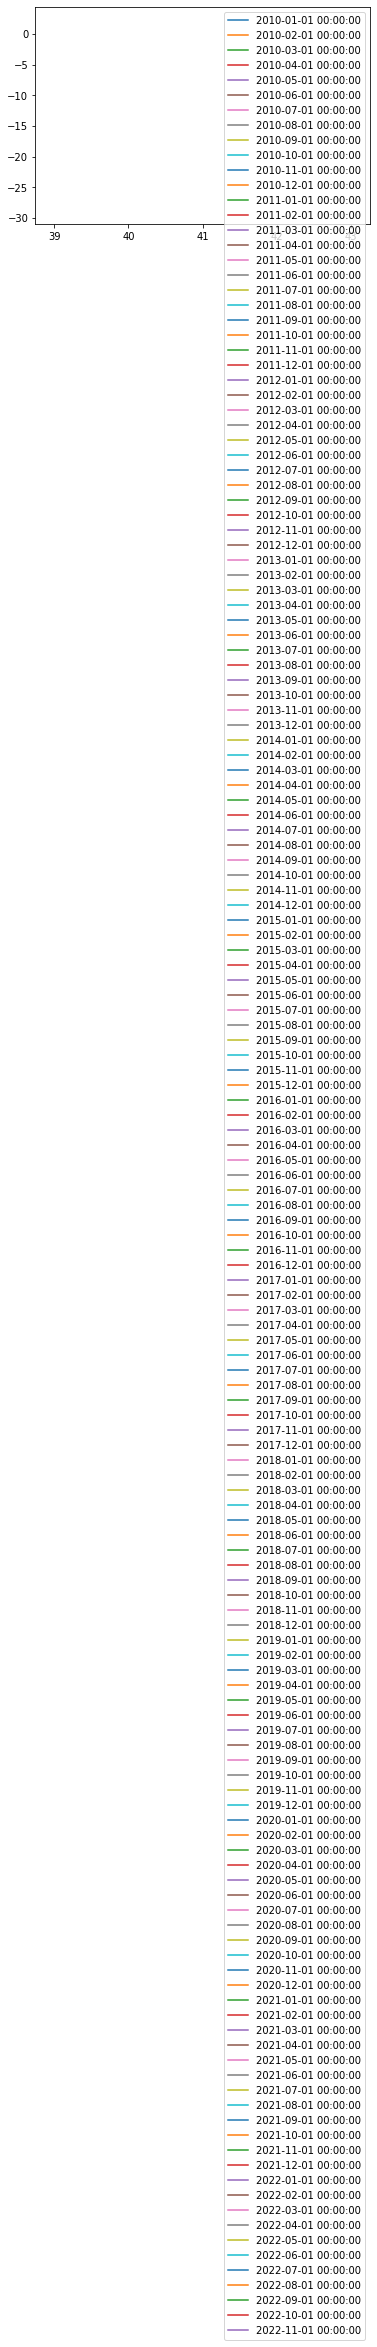

In [13]:
bs_de.plot()

Das hat leider nicht wie gewünscht funktioniert, weil der Plot die Werte in *vielen Zeilen* benötigt. Spalten und Zeilen vertauschen nennt sich *transponieren* und das kannst du in `pandas` einfach durch die Operation `.T` erreichen:

<AxesSubplot:>

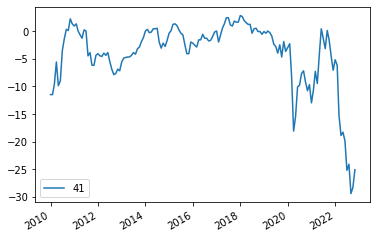

In [14]:
bs_de.T.plot()

Genau dieses Ergebnis wolltest du erreichen. Die *Corona-Krise* kannst du im Konsumindikator gut erkennen.

Willst du alle Konsumindikatoren über die Länder zu einem Zeitpunkt (z.B. Juni 2021) hinweg vergleichen, bietet sich dafür eine Tabelle an. Die Daten hast du allerdings nicht in der richtigen Form zur Verfügung, weil sowohl  Konsumindikatoren als auch Länder in den Zeilen dargestellt sind. Du möchtest aber die Konsumindikatoren in den Spalten und die Länder in den Zeilen haben.

Mit `pandas` geht das ganz einfach, denn dazu gibt es die Funktion `pivot`, der du einfach die Namen der Zeilen (`index`) und die Namen der Spalten (`columns`) übergibst. Zusätzlich musst du der Funktion mitteilen, welche Werte (aus den ursprünglichen Spalten) sie verwenden soll:

In [17]:
indic_country = df[df["s_adj"] == "SA"].pivot(index="country", columns="indic", 
                                              values=datetime(2022, 11, 1))
indic_country

indic,BS-CSMCI,BS-FS-LY,BS-FS-NY,BS-GES-LY,BS-GES-NY,BS-MP-NY,BS-MP-PR,BS-PT-LY,BS-PT-NY,BS-SFSH,BS-SV-NY,BS-SV-PR,BS-UE-NY
country,,,,,,,,,,,,,
AL,-22.4,-19.8,-4.9,-31.5,-13.0,-51.8,-66.1,50.3,-1.4,3.4,-40.3,-46.0,9.4
AT,-29.8,-23.4,-21.3,-46.9,-43.1,-31.3,-35.0,79.3,40.9,22.6,17.0,32.7,20.2
BE,-22.1,-22.4,-10.1,-68.1,-32.3,-23.7,-34.9,85.9,13.8,17.2,-5.9,-45.7,37.6
BG,-27.8,-29.9,-20.3,-56.0,-38.1,-23.0,-32.3,79.9,25.3,10.5,-37.1,-33.2,23.8
CY,-30.3,-24.3,-21.6,-51.2,-41.0,-34.5,-54.5,82.9,33.1,11.3,-46.1,-31.1,31.3
CZ,-29.8,-29.7,-26.2,-70.1,-48.9,-14.6,-40.6,61.4,35.3,22.5,-7.8,-44.8,43.9
DE,-25.1,-13.1,-16.9,-53.6,-45.7,-25.0,-38.7,75.8,42.7,23.6,11.9,30.6,33.0
DK,-17.8,-31.9,-4.9,-58.7,-9.9,-24.6,-41.4,72.5,6.4,19.6,15.0,60.3,21.8
EA19,-23.9,-20.5,-15.6,-59.8,-38.3,-21.2,-42.7,78.3,30.1,14.6,-1.5,NaN,26.0


Eine etwas übersichtlichere Darstellung erreichst du mit einer sog. *Heatmap*:

<AxesSubplot:xlabel='indic', ylabel='country'>

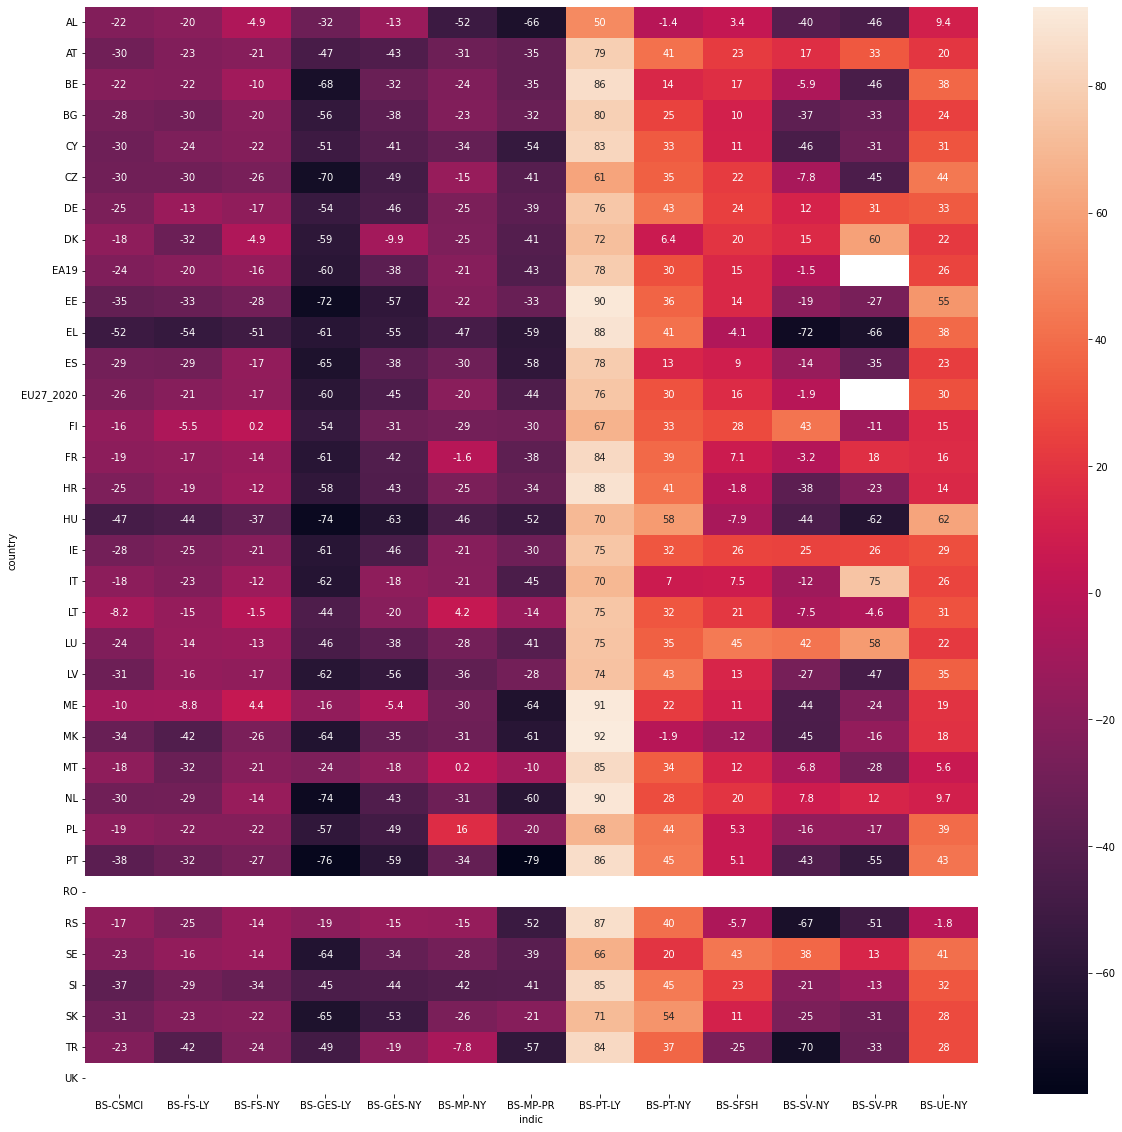

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
sns.heatmap(indic_country, annot=True)

Hier siehst du auf den ersten Blick, dass Rumänien keine Werte geliefert hat und der Indikator `BS_SV_PR` für die gesamte EU bzw. den Euro-Raum nicht berechnet wurde.